In [5]:
import copy
import pickle

import ajf_plts
import ajf_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ajf_bridge_fem import *
from pandarallel import pandarallel
from scipy import stats

pandarallel.initialize(progress_bar=True)

plt.style.use(["./ajf_plts/base.mplstyle", "./ajf_plts/legend_frame.mplstyle"])

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Load result data 

In [6]:
DAM_LOCS = ["L", "R"]
RUN_ID = "2023-01-22T23:19:22.013087_LB"

all_data = (
    pd.read_parquet(f"./{RUN_ID}_w_error")
    .sort_values(["year", "delta"])
    .reset_index(drop=True)
)

all_data.head()

,seq_month,year,month,day,hour,minute,dayofweek,air_temperature,freq,E_val,...,S1,S2,S3,S4,S5,speed,x_dam,delta,L,R
0,0,0,0,1,1,36,6,4.880000,5.786878,2.883737e+10,...,3.75,9.60,10.85,NaN,NaN,23.0,11.333333,0.0,0.000089,0.000089
1,0,0,0,1,4,43,6,3.555000,5.795990,2.892656e+10,...,4.50,5.85,NaN,NaN,NaN,24.0,11.333333,0.0,0.000128,0.000125
2,0,0,0,1,5,10,6,3.216667,5.799653,2.896242e+10,...,5.20,6.55,NaN,NaN,NaN,28.0,11.333333,0.0,0.000062,0.000061
3,0,0,0,1,5,12,6,3.200000,5.799898,2.896483e+10,...,5.95,7.45,NaN,NaN,NaN,27.5,11.333333,0.0,0.000112,0.000113
4,0,0,0,1,6,57,6,3.655000,5.801216,2.897772e+10,...,6.05,NaN,NaN,NaN,NaN,25.5,11.333333,0.0,0.000062,0.000061


# Only keep the columns that we need to make code run a bit faster

In [7]:
keep_cols = ["delta", "year", "AxleCount"] + DAM_LOCS
res_data = all_data.loc[:, keep_cols]

res_data

,delta,year,AxleCount,L,R
0,0.0,0,4,0.000089,0.000089
1,0.0,0,3,0.000128,0.000125
2,0.0,0,3,0.000062,0.000061
3,0.0,0,3,0.000112,0.000113
4,0.0,0,2,0.000062,0.000061
...,...,...,...,...,...
36701743,0.2,60,5,0.000096,0.000085
36701744,0.2,60,4,0.000158,0.000151
36701745,0.2,60,2,0.000047,0.000043
36701746,0.2,60,6,0.000146,0.000144


# Extract baseline

In [8]:
baseline = res_data.loc[(res_data.year == 0) & (res_data.delta == 0.0)]

In [9]:
deltas = res_data.index.get_level_values("delta").unique()
max_year = res_data.index.get_level_values("year").max()

KeyError: 'Requested level (delta) does not match index name (None)'

In [ ]:
AXLE_NUMS = [np.arange(2, 7), np.arange(5, 6), np.arange(6, 7)]
AXLE_NAMES = ["All", "5ax", "6ax"]


def calc_emd(df):
    return dict(
        zip(
            [l + "_" + n for n in AXLE_NAMES for l in DAM_LOCS],
            [
                stats.wasserstein_distance(
                    baseline.loc[baseline.AxleCount.isin(axles), l].values,
                    df.loc[df.AxleCount.isin(axles), l].values,
                )
                for axles in AXLE_NUMS
                for l in DAM_LOCS
            ],
        )
    )

In [155]:
emd_vals = res_data.groupby(["delta", "year"]).parallel_apply(calc_emd)
emd_df = pd.DataFrame(
    emd_vals.to_list(),
    index=emd_vals.index,
)
emd_df = emd_df.dropna()

In [233]:
delta_vals = res_data.delta.unique()
years = res_data.year.unique()[1:]  # remove baseline
year_delta_df = pd.DataFrame(
    years,
    index=delta_vals[
        (np.arange(1, max_year + 1) - 1) // (years.max() // len(delta_vals))
    ],
    columns=["year"],
)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [240]:
group.loc[delta].loc[year_delta_df.loc[delta].values.flatten(), "L_All"]

year
1     7.957504e-07
2     4.623178e-07
3     1.668827e-07
4     6.211995e-07
5     5.296075e-07
6     1.656776e-07
7     3.060565e-07
8     1.241343e-07
9     2.186625e-07
10    3.322604e-07
Name: L_All, dtype: float64

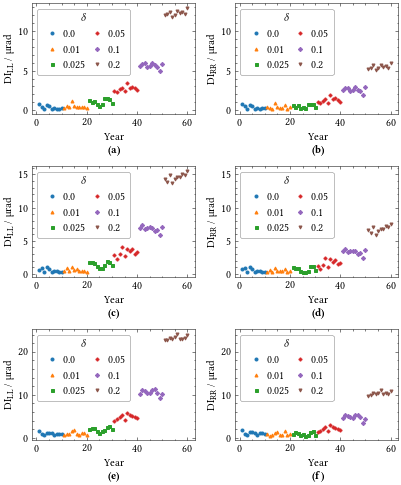

In [288]:
plt.style.use(
    [
        "./ajf_plts/base.mplstyle",
        "./ajf_plts/legend_frame.mplstyle",
        "./ajf_plts/lines_markers.mplstyle",
    ]
)

figsize = (ajf_plts.text_width_inches, len(AXLE_NUMS) * ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, ncols=len(DAM_LOCS), nrows=len(AXLE_NUMS))

for i, axles in enumerate(AXLE_NAMES):
    for j, pos in enumerate(DAM_LOCS):
        for delta, group in emd_df.groupby("delta"):
            axes[i, j].plot(
                group.loc[delta].loc[
                    year_delta_df.loc[delta].values.flatten(), f"{pos}_{axles}"
                ]
                * 1e6,
                ls="",
                label=delta,
            )

for a in axes.ravel():
    _ = a.set_xlabel("Year")
    _ = a.legend(
        loc="upper left", title="$\delta$", ncol=2, handletextpad=0.0, columnspacing=0.0
    )

for a in axes[:, 0]:
    _ = a.set_ylabel(r"$\mathrm{DI_{LL}}$ / \unit{\micro\radian}")

for a in axes[:, -1]:
    _ = a.set_ylabel(r"$\mathrm{DI_{RR}}$ / \unit{\micro\radian}")

for row in axes[0:, :]:
    for a in row:
        _ = a.set_ylim(row[0].get_ylim())

ajf_plts.caption_axes(axes.ravel())
fig.tight_layout(h_pad=1.0)

ajf_plts.save_fig(fig, "figNoSamplingStepsStairs.pdf")

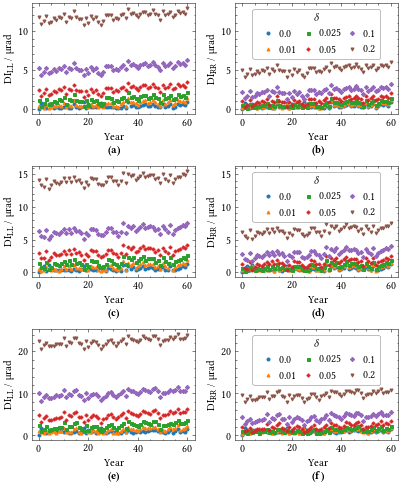

In [289]:
plt.style.use(
    [
        "./ajf_plts/base.mplstyle",
        "./ajf_plts/legend_frame.mplstyle",
        "./ajf_plts/lines_markers.mplstyle",
    ]
)

figsize = (ajf_plts.text_width_inches, len(AXLE_NUMS) * ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, ncols=len(DAM_LOCS), nrows=len(AXLE_NUMS))

for i, axles in enumerate(AXLE_NAMES):
    for j, pos in enumerate(DAM_LOCS):
        for delta, group in emd_df.groupby("delta"):
            axes[i, j].plot(
                group.loc[:, f"{pos}_{axles}"].values * 1e6, ls="", label=delta
            )

for a in axes.ravel():
    _ = a.set_xlabel("Year")

for a in axes[:, 0]:
    _ = a.set_ylabel(r"$\mathrm{DI_{LL}}$ / \unit{\micro\radian}")

for a in axes[:, -1]:
    _ = a.set_ylabel(r"$\mathrm{DI_{RR}}$ / \unit{\micro\radian}")
    _ = a.legend(
        loc="upper center",
        title="$\delta$",
        ncol=3,
        handletextpad=0.0,
        columnspacing=0.0,
    )

for row in axes[0:, :]:
    for a in row:
        _ = a.set_ylim(row[0].get_ylim())

ajf_plts.caption_axes(axes.ravel())
fig.tight_layout(h_pad=1.0)

ajf_plts.save_fig(fig, "figNoSamplingScatter60years.pdf")

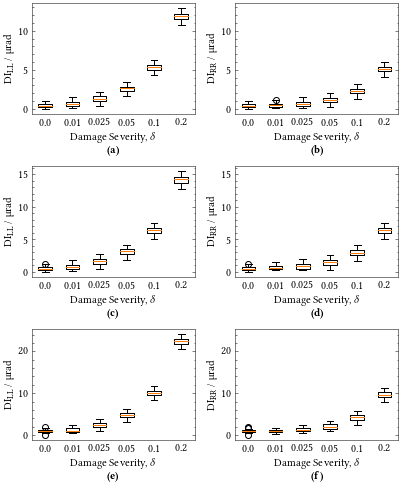

In [290]:
plt.style.use(
    [
        "./ajf_plts/base.mplstyle",
        "./ajf_plts/legend_frame.mplstyle",
        "./ajf_plts/lines_markers.mplstyle",
    ]
)

figsize = (ajf_plts.text_width_inches, len(AXLE_NUMS) * ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, ncols=len(DAM_LOCS), nrows=len(AXLE_NUMS))

for i, axles in enumerate(AXLE_NAMES):
    for j, pos in enumerate(DAM_LOCS):
        data = []
        for delta, group in emd_df.groupby("delta"):
            data.append(group.loc[:, f"{pos}_{axles}"].values * 1e6)
        bp = axes[i, j].boxplot(data)
        #    _ = ax.boxplot(group.loc[:, f"{pos}_{axles}"].values)
#            axes[i, j].plot(
#                group.loc[:, f"{pos}_{axles}"].values * 1e6, ls="", label=delta
#            )


for a in axes.ravel():
    a.set_xlabel("Damage Severity, $\delta$")
    a.set_xticklabels(delta_vals)
    a.tick_params(axis="x", which="both", bottom=False, top=False)

for a in axes[:, 0]:
    _ = a.set_ylabel(r"$\mathrm{DI_{LL}}$ / \unit{\micro\radian}")

for a in axes[:, -1]:
    _ = a.set_ylabel(r"$\mathrm{DI_{RR}}$ / \unit{\micro\radian}")
#    _ = a.legend(
#        loc="upper center",
#        title="$\delta$",
#        ncol=3,
#        handletextpad=0.0,
#        columnspacing=0.0,
#    )

for row in axes[0:, :]:
    for a in row:
        _ = a.set_ylim(row[0].get_ylim())

ajf_plts.caption_axes(axes.ravel())
fig.tight_layout(h_pad=1.0)

ajf_plts.save_fig(fig, "figNoSamplingBoxPlots.pdf")

# Table of stats tests

In [372]:
# Freedman-Diaconis rule
def get_rv_hist(vals):
    h = 2.0 * stats.iqr(vals) * np.power(len(vals), -1.0 / 3.0)
    n_bins = int(np.ptp(vals) // h)
    return stats.rv_histogram(np.histogram(vals, bins=n_bins))

False

In [399]:
pos = "L"
axles = "All"
col = f"{pos}_{axles}"
ALPHA = 0.05

N_healthy = 5
N_damaged = 5
N_hd = N_healthy + N_damaged

In [402]:
[np.arange(0, N_hd) + x for x in np.arange(1, years.max() - N_hd + 1)]

[array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17]),
 array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]),
 array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
 array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
 array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21]),
 array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22]),
 array([14, 15, 16, 17, 18, 19, 20, 21, 22, 23]),
 array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24]),
 array([16, 17, 18, 19, 20, 21, 22, 23, 24, 25]),
 array([17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 array([19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),


['L_All', 'L_5ax', 'L_6ax', 'R_All', 'R_5ax', 'R_6ax']

In [481]:
loc_veh_pairs = [f"{l}_{a}" for l in DAM_LOCS for a in AXLE_NAMES]
ALPHA = 0.05
CONF = 1.0 - ALPHA

print("Delta  ", end="")
for lv in loc_veh_pairs:
    print(lv + "    ", end="")
print()

for d1 in delta_vals:
    print(f"{d1:.3f}  ", end="")
    for lv in loc_veh_pairs:
        emd0 = get_rv_hist(emd_df.loc[0.0, lv].values)
        emd1 = get_rv_hist(emd_df.loc[d1, lv].values)
        ci_sep = emd0.interval(CONF)[1] < emd1.interval(CONF)[0]
        print("True " if ci_sep else "False", end="    ")
    print()

Delta  L_All    L_5ax    L_6ax    R_All    R_5ax    R_6ax    
0.000  False    False    False    False    False    False    
0.010  False    False    False    False    False    False    
0.025  False    False    False    False    False    False    
0.050  True     True     True     False    False    False    
0.100  True     True     True     True     True     True     
0.200  True     True     True     True     True     True     


In [511]:
print("Delta\t", end="")
for lv in loc_veh_pairs:
    print(lv + "\t", end="\t")
print()

for d1 in delta_vals:
    print(f"{d1:.3f}\t", end="")
    for lv in loc_veh_pairs:
        emd0 = get_rv_hist(emd_df.loc[0.0, lv].values)
        emd1 = get_rv_hist(emd_df.loc[d1, lv].values)
        ci_sep = emd0.interval(CONF)[1] < emd1.interval(CONF)[0]
        ci = emd1.interval(CONF)
        print(f"({ci[0]:.3}, {ci[1]:.3})", end="\t")
    print()

Delta	L_All		L_5ax		L_6ax		R_All		R_5ax		R_6ax		
0.000	(3.36e-08, 9.3e-07)	(1.87e-07, 1.18e-06)	(4.63e-07, 1.7e-06)	(3.68e-08, 9.07e-07)	(1.82e-07, 1.15e-06)	(3.66e-07, 1.76e-06)	
0.010	(1.76e-07, 1.33e-06)	(2.31e-07, 1.71e-06)	(5.63e-07, 2.27e-06)	(1.75e-07, 1.05e-06)	(2.61e-07, 1.36e-06)	(3.81e-07, 1.71e-06)	
0.025	(4.91e-07, 2.06e-06)	(5.52e-07, 2.6e-06)	(1.13e-06, 3.63e-06)	(1.86e-07, 1.36e-06)	(2.53e-07, 1.84e-06)	(5.62e-07, 2.2e-06)	
0.050	(1.67e-06, 3.36e-06)	(2e-06, 4.12e-06)	(3.21e-06, 6.06e-06)	(3.59e-07, 1.87e-06)	(4.7e-07, 2.48e-06)	(9.14e-07, 3.36e-06)	
0.100	(4.41e-06, 6.16e-06)	(5.32e-06, 7.45e-06)	(8.45e-06, 1.14e-05)	(1.43e-06, 3.05e-06)	(1.84e-06, 3.98e-06)	(2.67e-06, 5.56e-06)	
0.200	(1.09e-05, 1.27e-05)	(1.3e-05, 1.53e-05)	(2.07e-05, 2.39e-05)	(4.17e-06, 5.88e-06)	(5.32e-06, 7.42e-06)	(8.04e-06, 1.1e-05)	


In [519]:
for d1 in delta_vals:
    print(f"{d1}", end="")
    for lv in loc_veh_pairs:
        emd0 = get_rv_hist(emd_df.loc[0.0, lv].values * 1e6)  # convert to urad
        emd1 = get_rv_hist(emd_df.loc[d1, lv].values * 1e6)  # convert to urad
        ci_sep = emd0.interval(CONF)[1] < emd1.interval(CONF)[0]
        ci = emd1.interval(CONF)
        print(
            " & " + (r"\bfseries" if ci_sep else "") + f"({ci[0]:.3}, {ci[1]:.3})",
            end="",
        )
    print(r"\\")

0.0 & (0.0336, 0.93) & (0.187, 1.18) & (0.463, 1.7) & (0.0368, 0.907) & (0.182, 1.15) & (0.366, 1.76)\\
0.01 & (0.176, 1.33) & (0.231, 1.71) & (0.563, 2.27) & (0.175, 1.05) & (0.261, 1.36) & (0.381, 1.71)\\
0.025 & (0.491, 2.06) & (0.552, 2.6) & (1.13, 3.63) & (0.186, 1.36) & (0.253, 1.84) & (0.562, 2.2)\\
0.05 & \bfseries(1.67, 3.36) & \bfseries(2.0, 4.12) & \bfseries(3.21, 6.06) & (0.359, 1.87) & (0.47, 2.48) & (0.914, 3.36)\\
0.1 & \bfseries(4.41, 6.16) & \bfseries(5.32, 7.45) & \bfseries(8.45, 11.4) & \bfseries(1.43, 3.05) & \bfseries(1.84, 3.98) & \bfseries(2.67, 5.56)\\
0.2 & \bfseries(10.9, 12.7) & \bfseries(13.0, 15.3) & \bfseries(20.7, 23.9) & \bfseries(4.17, 5.88) & \bfseries(5.32, 7.42) & \bfseries(8.04, 11.0)\\


In [457]:
pos = "L"
axles = "6ax"
col = f"{pos}_{axles}"
ALPHA = 0.05

print("       ", end="")
for d in delta_vals:
    print(f"{d:.3f}    ", end="")
print()

for d1 in delta_vals:
    print(f"{d1:.3f}  ", end="")
    for d2 in delta_vals:
        if d2 < d1:
            print("     ", end="    ")
        else:
            emd1 = get_rv_hist(emd_df.loc[d1, col].values)
            emd2 = get_rv_hist(emd_df.loc[d2, col].values)
            ci_sep = emd1.interval(1.0 - ALPHA)[1] < emd2.interval(1.0 - ALPHA)[0]
            print(f"{ci_sep}", end="    ")
            # res = stats.median_test(
            #    emd_df.loc[d1, col].values,
            #    emd_df.loc[d2, col].values,
            # )
            # print(f"{res.pvalue:.3f}", end="    ")
    print()

       0.000    0.010    0.025    0.050    0.100    0.200    
0.000  False    False    False    True    True    True    
0.010           False    False    True    True    True    
0.025                    False    False    True    True    
0.050                             False    True    True    
0.100                                      False    True    
0.200                                               False    


In [456]:
emd1 = emd_df.loc[0.0, col].values
emd2 = emd_df.loc[0.05, col].values
emd3 = emd_df.loc[0.1, col].values
emd4 = emd_df.loc[0.2, col].values

np.allclose((emd2 - emd1) + (emd3 - emd2), (emd3 - emd1))

True

In [421]:
np.unique(np.abs(np.array([d - delta_vals for d in delta_vals])))

array([0.   , 0.01 , 0.015, 0.025, 0.04 , 0.05 , 0.075, 0.09 , 0.1  ,
       0.15 , 0.175, 0.19 , 0.2  ])

In [367]:
pos = "R"
axles = "6ax"
col = f"{pos}_{axles}"

print("       ", end="")
for d in delta_vals:
    print(f"{d:.3f}    ", end="")
print()

for d1 in delta_vals:
    print(f"{d1:.3f}  ", end="")
    for d2 in delta_vals:
        if d2 < d1:
            print("     ", end="    ")
        else:
#            ks_res = stats.mannwhitneyu(
#                emd_df.loc[d1, col].values[:10], emd_df.loc[d2, col].values[:10], alternative="less"
#            )
            stats.
            print(f"{ks_res.pvalue:.3f}", end="    ")
    print()

       0.000    0.010    0.025    0.050    0.100    0.200    
0.000  0.515    0.828    0.939    0.038    0.000    0.000    
0.010           0.515    0.688    0.005    0.000    0.000    
0.025                    0.515    0.001    0.000    0.000    
0.050                             0.515    0.000    0.000    
0.100                                      0.515    0.000    
0.200                                               0.515    


In [ ]:
fig, axes = plt.subplots(
    figsize=(ajf_plts.text_width_inches, ajf_plts.text_height_inches),
    nrows=len(locs),
    sharex=True,
    sharey=True,
)

emds = [
    res_df.groupby("year")[locs[i]].apply(
        lambda s: stats.wasserstein_distance(baseline[locs[i]], s)
    )
    for i in range(len(locs))
]

for i, group in res_df.groupby("delta"):
    for j, loc in enumerate(locs):
        axes[j].plot(
            group.year.unique(),
            emds[j][group.year.unique()],
            ls="",
            marker=".",
            label=group.delta.max(),
        )
        axes[j].set_title(loc)

for ax in axes.ravel():
    ax.set_xlabel("Year")
    ax.set_ylabel(r"EMD / \unit{\micro\radian}")
    ax.legend(
        loc="upper left",
        borderpad=0.1,
        labelspacing=0.1,
        handletextpad=0.2,
    )


fig.tight_layout()

In [ ]:
mean_temp = baseline.air_temperature.mean()
std_temp = baseline.air_temperature.std()

In [ ]:
baseline_temp_mask = np.abs(baseline.air_temperature - mean_temp) / std_temp < 0.5
temp_mask = np.abs(res_df.air_temperature - mean_temp) / std_temp < 0.5

baseline_veh_mask = baseline.AxleCount == 6
veh_mask = res_df.AxleCount == 6

In [ ]:
baseline_ran_mask = (baseline_temp_mask & baseline_veh_mask).sample(frac=1)

In [ ]:
emd_ll = res_df.groupby("year")[locs[1]].apply(
    lambda s: stats.wasserstein_distance(baseline[locs[1]], s)
)
emd_rr = res_df.groupby("year")[locs[2]].apply(
    lambda s: stats.wasserstein_distance(baseline[locs[2]], s)
)

emd_ll_vs = (
    res_df[veh_mask]
    .groupby("year")[locs[1]]
    .apply(
        lambda s: stats.wasserstein_distance(baseline[baseline_veh_mask][locs[1]], s)
    )
)
emd_rr_vs = (
    res_df[veh_mask]
    .groupby("year")[locs[2]]
    .apply(
        lambda s: stats.wasserstein_distance(baseline[baseline_veh_mask][locs[2]], s)
    )
)

emd_ll_ts = (
    res_df[temp_mask]
    .groupby("year")[locs[1]]
    .apply(
        lambda s: stats.wasserstein_distance(baseline[baseline_temp_mask][locs[1]], s)
    )
)
emd_rr_ts = (
    res_df[temp_mask]
    .groupby("year")[locs[2]]
    .apply(
        lambda s: stats.wasserstein_distance(baseline[baseline_temp_mask][locs[2]], s)
    )
)

emd_ll_tvs = (
    res_df[temp_mask & veh_mask]
    .groupby("year")[locs[1]]
    .apply(
        lambda s: stats.wasserstein_distance(
            baseline[baseline_temp_mask & baseline_veh_mask][locs[1]], s
        )
    )
)
emd_rr_tvs = (
    res_df[temp_mask & veh_mask]
    .groupby("year")[locs[2]]
    .apply(
        lambda s: stats.wasserstein_distance(
            baseline[baseline_temp_mask & baseline_veh_mask][locs[2]], s
        )
    )
)

emd_ll_ran = (
    res_df.groupby("year")
    .sample(baseline_ran_mask.sum())
    .groupby("year")[locs[1]]
    .apply(lambda s: stats.wasserstein_distance(baseline[locs[1]], s))
)
emd_rr_ran = (
    res_df.groupby("year")
    .sample(baseline_ran_mask.sum())
    .groupby("year")[locs[2]]
    .apply(lambda s: stats.wasserstein_distance(baseline[locs[2]], s))
)

In [ ]:
fig, axes = plt.subplots(
    figsize=(ajf_plts.text_width_inches, 0.5 * ajf_plts.text_height_inches),
    ncols=2,
    nrows=2,
    sharex=True,
    sharey=True,
)

axes = axes.ravel()

for i, group in res_df.groupby("delta"):
    axes[0].plot(
        group.year.unique(),
        emd_ll[group.year.unique()],
        ls="",
        marker=".",
        label=group.delta.max(),
    )
    axes[1].plot(
        group.year.unique(),
        emd_rr[group.year.unique()],
        ls="",
        marker=".",
        label=group.delta.max(),
    )
    axes[2].plot(
        group.year.unique(),
        emd_ll_vs[group.year.unique()],
        ls="",
        marker=".",
        label=group.delta.max(),
    )
    axes[3].plot(
        group.year.unique(),
        emd_rr_vs[group.year.unique()],
        ls="",
        marker=".",
        label=group.delta.max(),
    )

for ax in axes.ravel():
    ax.set_xlabel("Year")
#    ax.legend(loc='upper left',
#              borderpad=0.1,
#              labelspacing=0.1,
#              handletextpad=0.2,)

for ax in axes[0::2]:
    ax.set_ylabel("EMD")

titles = (
    [r"All Samples $\sim 100k$/year"] * 2
    + [r"Only 6 axle $\sim 12.5k$/year"] * 2
    + [r"Temp $<$ 0.25SD $\sim 12.5k$/year"] * 2
    + [r"6 axle \& Temp $<$ 0.25SD $\sim 1.7k$/year"] * 2
    + [r"Random with $\sim 1.7k$/year"] * 2
)

for i, ax in enumerate(axes):
    ax.set_title(titles[i])

fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(
    figsize=(ajf_plts.text_width_inches, ajf_plts.text_height_inches),
    ncols=2,
    nrows=5,
    sharex=True,
    sharey=True,
)

axes = axes.ravel()

for i, group in res_df.groupby("delta"):
    axes[0].plot(
        group.year.unique(),
        emd_ll[group.year.unique()],
        ls="",
        marker=".",
        label=group.delta.max(),
    )
    axes[1].plot(
        group.year.unique(),
        emd_rr[group.year.unique()],
        ls="",
        marker=".",
        label=group.delta.max(),
    )
    axes[2].plot(
        group.year.unique(),
        emd_ll_vs[group.year.unique()],
        ls="",
        marker=".",
        label=group.delta.max(),
    )
    axes[3].plot(
        group.year.unique(),
        emd_rr_vs[group.year.unique()],
        ls="",
        marker=".",
        label=group.delta.max(),
    )
    axes[4].plot(
        group.year.unique(),
        emd_ll_ts[group.year.unique()],
        ls="",
        marker=".",
        label=group.delta.max(),
    )
    axes[5].plot(
        group.year.unique(),
        emd_rr_ts[group.year.unique()],
        ls="",
        marker=".",
        label=group.delta.max(),
    )
    axes[6].plot(
        group.year.unique(),
        emd_ll_tvs[group.year.unique()],
        ls="",
        marker=".",
        label=group.delta.max(),
    )
    axes[7].plot(
        group.year.unique(),
        emd_rr_tvs[group.year.unique()],
        ls="",
        marker=".",
        label=group.delta.max(),
    )
    axes[8].plot(
        group.year.unique(),
        emd_ll_ran[group.year.unique()],
        ls="",
        marker=".",
        label=group.delta.max(),
    )
    axes[9].plot(
        group.year.unique(),
        emd_rr_ran[group.year.unique()],
        ls="",
        marker=".",
        label=group.delta.max(),
    )

for ax in axes.ravel():
    ax.set_xlabel("Year")
#    ax.legend(loc='upper left',
#              borderpad=0.1,
#              labelspacing=0.1,
#              handletextpad=0.2,)

for ax in axes[0::2]:
    ax.set_ylabel("EMD")

titles = (
    [r"All Samples $\sim 100k$/year"] * 2
    + [r"Only 6 axle $\sim 12.5k$/year"] * 2
    + [r"Temp $<$ 0.25SD $\sim 12.5k$/year"] * 2
    + [r"6 axle \& Temp $<$ 0.25SD $\sim 1.7k$/year"] * 2
    + [r"Random with $\sim 1.7k$/year"] * 2
)

for i, ax in enumerate(axes):
    ax.set_title(titles[i])

fig.tight_layout()